In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000
gamma=0.99
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=50000

batch_size=32

In [9]:
env = gym.make('CartPole-v1')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [15]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
            
        new_state_values=self.nn(new_state).detach()
        #print('shape of: new_state_values')
        #print(new_state_values.shape)
        
        max_new_state_values=torch.max(new_state_values,dim=1)[0]
        #print('shape of: max_new_state_values')
        #print(max_new_state_values.shape)
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [16]:
memory=ExperienceReplay(replay_memory_size)

In [17]:
qnet_agent=QNet_Agent()

In [18]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [19]:
%%time

num_episodes=1000

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 17.3
Average over all episodes so far: 17.3
epsilon: 0.5678063822595644
**** Episode  20 **** 
Recent average reward: 108.8
Average over all episodes so far: 63.05
epsilon: 0.06390033308773407
**** Episode  30 **** 
Recent average reward: 208.0
Average over all episodes so far: 111.36666666666666
epsilon: 0.02046020736733318
**** Episode  40 **** 
Recent average reward: 261.7
Average over all episodes so far: 148.95
epsilon: 0.02000418571353014
**** Episode  50 **** 
Recent average reward: 234.6
Average over all episodes so far: 166.08
epsilon: 0.020000019834690803
**** Episode  60 **** 
Recent average reward: 423.8
Average over all episodes so far: 209.03333333333333
epsilon: 0.020000000007309594
**** Episode  70 **** 
Recent average reward: 279.3
Average over all episodes so far: 219.07142857142858
epsilon: 0.020000000000019707
**** Episode  80 **** 
Recent average reward: 459.5
Average over all episodes so far: 249.125
epsilon: 0.02
****

**** Episode  590 **** 
Recent average reward: 495.9
Reward over last 100: 477.43
Average over all episodes so far: 416.8525423728814
epsilon: 0.02
**** Episode  600 **** 
Recent average reward: 472.2
Reward over last 100: 474.98
Average over all episodes so far: 417.775
epsilon: 0.02
**** Episode  610 **** 
Recent average reward: 417.3
Reward over last 100: 467.73
Average over all episodes so far: 417.7672131147541
epsilon: 0.02
**** Episode  620 **** 
Recent average reward: 402.6
Reward over last 100: 462.28
Average over all episodes so far: 417.52258064516127
epsilon: 0.02
**** Episode  630 **** 
Recent average reward: 378.1
Reward over last 100: 451.34
Average over all episodes so far: 416.8968253968254
epsilon: 0.02
**** Episode  640 **** 
Recent average reward: 470.5
Reward over last 100: 450.04
Average over all episodes so far: 417.734375
epsilon: 0.02
**** Episode  650 **** 
Recent average reward: 457.2
Reward over last 100: 447.64
Average over all episodes so far: 418.34153846

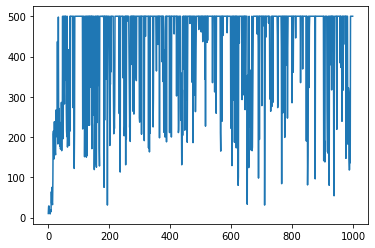

In [20]:
plt.plot(steps_total)
plt.show()

In [21]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 424.796


In [22]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 424.796
Average number of steps=reward in last 100 episodes: 409.72


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

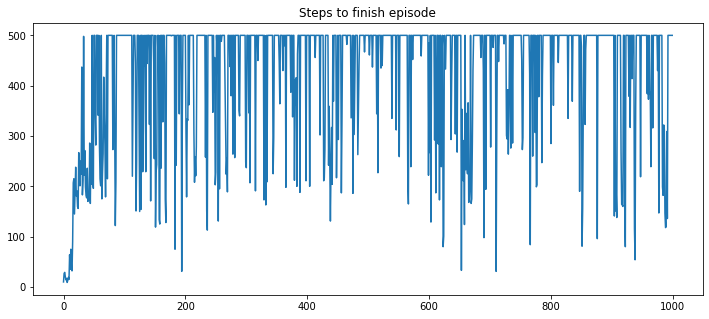

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()